In [1]:
# Import modules and packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas as pd
import seaborn as sns
import re
from scipy.stats import gaussian_kde
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import unidecode
import unicodedata
%matplotlib inline

In [4]:
df = pd.read_csv('CompleteNBAPlayerLineupStats.csv')

#df['WAVG_OPP_FGP'].fillna(0, inplace=True)
#df[df.isna().any(axis=1)]
#print(df.columns[df.isna().any()].tolist())

#df.dropna(inplace=True)

min_GP = 40
min_MPG = 10
min_GPT = 5
min_MPT = 30

#df = df.groupby(['code'], as_index=False).filter(lambda s: s['name'].count() == 5)
df = df[df.GP >= min_GP]
df = df[df.MPG >= min_MPG]
df = df[df.MPT >= min_MPT]
df = df[df.GPT >= min_GPT]

print(df)


                  name pos team  year    GP    GS  height  weight     college  \
0        Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0        None   
1        Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0        None   
2        Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0        None   
3        Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0        None   
4        Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0        None   
...                ...  ..  ...   ...   ...   ...     ...     ...         ...   
182744   Darius Bazley  PF  OKC  2020  40.0   6.0    80.0   208.0        None   
182817  Darius Garland  PG  CLE  2020  40.0  40.0    73.0   192.0  Vanderbilt   
182818  Darius Garland  PG  CLE  2020  40.0  40.0    73.0   192.0  Vanderbilt   
182819  Darius Garland  PG  CLE  2020  40.0  40.0    73.0   192.0  Vanderbilt   
182820  Darius Garland  PG  CLE  2020  40.0  40.0    73.0   192.0  Vanderbilt   

        country  ...   TST 

In [6]:
#df = df.groupby(['name'], as_index=False).mean()
#df_train = df[df.year.values < 2019].groupby(['name'], as_index=False).mean()
#df_test = df[df.year.values == 2019].groupby(['name'], as_index=False).mean()
df_train = df[df.year.values < 2019].groupby(['name', 'year'], as_index=False).mean()
df_test = df[df.year.values == 2019].groupby(['name', 'year'], as_index=False).mean()
print(df_train)
print(df_test)
print("Using a training dataset of size:", len(df_train))
print("Using a test dataset of size:", len(df_test))


              name  year    GP    GS  height  weight  actual_draft_year  \
0     Aaron Brooks  2017  65.0   0.0    72.0   161.0             2007.0   
1     Aaron Gordon  2017  80.0  72.0    81.0   220.0             2014.0   
2     Aaron Gordon  2018  58.0  57.0    81.0   220.0             2014.0   
3      Abdel Nader  2018  48.0   1.0    78.0   230.0             2016.0   
4       Al Horford  2017  68.0  68.0    82.0   245.0             2007.0   
..             ...   ...   ...   ...     ...     ...                ...   
527    Zach LaVine  2017  47.0  47.0    77.0   183.0             2014.0   
528  Zach Randolph  2017  73.0   5.0    81.0   270.0             2001.0   
529  Zach Randolph  2018  59.0  57.0    81.0   270.0             2001.0   
530  Zaza Pachulia  2017  70.0  70.0    83.0   240.0             2003.0   
531  Zaza Pachulia  2018  69.0  57.0    83.0   240.0             2003.0   

     draft_round  draft_number  draft_year  ...      EFGPT        TST  \
0            1.0          

In [7]:
#age,GP,GS,MPG,WLR,
###
#PTS_PT,FGM_PT,FGA_PT,FGP_PT,3PM_PT,3PA_PT,3PP_PT,FTM_PT,FTA_PT,FTP_PT,
#ORB_PT,DRB_PT,TRB_PT,AST_PT,TOV_PT,STL_PT,BLK_PT,PF_PT,PM_PT,
#PTS_OFF_TOV_PT,SEC_CHANCE_PTS_PT,FB_PTS_PT,PTS_PAINT_PT,BLK_ATTEMPT_PT,PF_DRAWN_PT,
#OPP_PTS_TOV_PT,OPP_PTS_2ND_PT,OPP_PTS_FB_PT,OPP_PTS_PAINT_PT,
###
#PTS_PH,FGM_PH,FGA_PH,FGP_PH,3PM_PH,3PA_PH,3PP_PH,FTM_PH,FTA_PH,FTP_PH,
#ORB_PH,DRB_PH,TRB_PH,AST_PH,TOV_PH,STL_PH,BLK_PH,PF_PH,PM_PH,
#PTS_OFF_TOV_PH,SEC_CHANCE_PTS_PH,FB_PTS_PH,PTS_PAINT_PH,BLK_ATTEMPT_PH,PF_DRAWN_PH,
#OPP_PTS_TOV_PH,OPP_PTS_2ND_PH,OPP_PTS_FB_PH,OPP_PTS_PAINT_PH,
#
#PERC_FGM,PERC_FGA,PERC_3PM,PERC_3PA,PERC_FTM,PERC_FTA,PERC_ORB,PERC_DRB,PERC_TRB,PERC_AST,PERC_TOV,PERC_STL,PERC_BLK,PERC_PTS,
#SCREEN_AST_PT,SCREEN_AST_PTS_PT,DEFL_PT,OFF_LB_RECOV_PT,DEF_LB_RECOV_PT,LB_RECOV_PT,PERC_OFF_LB_RECOV_PT,PERC_DEF_LB_RECOV_PT,CHARGE_DRAWN_PT,CONTESTS_2PT_PT,CONTESTS_3PT_PT,CONTESTS_PT,
#DIST_FEET_PG,DIST_M_PG,DIST_M_OFF,DIST_M_DEF,AVG_SPEED,AVG_SPEED_OFF,AVG_SPEED_DEF,
#
#FTR,EFGP,TS,ASTR,TOR,USG,ORR,DRR,REBR,PACE,PIE,OFFRTG,DEFRTG,NETRTG,OWS,DWS,WS,WS48,OBPM,DBPM,BPM,VORP,PER,VA,EWA
#ATR,2PM_PH,2PA_PH,2PP_PH,2PM_PT,2PA_PT,2PP_PT,2PR,3PR,ODRR,AVG_OPP_FGP,WAVG_OPP_FGP
#
#OFF_POSS_ISO,OFF_FREQ_ISO,OFF_PPP_ISO,OFF_FGP_ISO,OFF_EFGP_ISO,OFF_FT_FREQ_ISO,OFF_TO_FREQ_ISO,OFF_SF_FREQ_ISO,OFF_AND1_FREQ_ISO,OFF_SCORE_FREQ_ISO
#DEF_POSS_ISO,DEF_FREQ_ISO,DEF_PPP_ISO,DEF_FGP_ISO,DEF_EFGP_ISO,DEF_FT_FREQ_ISO,DEF_TO_FREQ_ISO,DEF_SF_FREQ_ISO,DEF_AND1_FREQ_ISO,DEF_SCORE_FREQ_ISO

#x_train = df_train[['PTS_PH', 'TS', 'ASTR', 'TOR', 'ORR', 'DRR', 'AVG_SPEED_OFF', 'AVG_SPEED_DEF', 'PACE', 'PF_PH', 'PF_DRAWN_PH', 'WAVG_OPP_FGP', 'CONTESTS_PT', 'LB_RECOV_PT', 'DEFL_PT']]
#y_train = df_train[['PM_PH']]
#x_test = df_test[['PTS_PH', 'TS', 'ASTR', 'TOR', 'ORR', 'DRR', 'AVG_SPEED_OFF', 'AVG_SPEED_DEF', 'PACE', 'PF_PH', 'PF_DRAWN_PH', 'WAVG_OPP_FGP', 'CONTESTS_PT', 'LB_RECOV_PT', 'DEFL_PT']]
#y_test = df_test[['PM_PH']]

# Features correlated with offensive rating
# PTS_PH (?), TS, PACE, ASTR OR ATR (?), TOR, LB_RECOV_PT, PF_DRAWN_PH, AVG_SPEED_OFF (?), PF_PH, ORR OR TRR (?)
#
# age, PTS_PH, TS, FTR, ASTR, TOR, ORR, DRR, REBR, LB_RECOV_PT, PTS_OFF_TOV_PH, SEC_CHANCE_PTS_PH, FB_PTS_PH, PTS_PAINT_PH, PF_DRAWN_PH, PACE, DIST_M_OFF, AVG_SPEED_OFF

x_train = df_train[['age', 'PTS_PH', 'TS', 'FTR', 'ASTR', 'TOR', 'ORR', 'DRR', 'REBR', 'LB_RECOV_PT', 'PTS_OFF_TOV_PH', 'SEC_CHANCE_PTS_PH', 'FB_PTS_PH', 'PTS_PAINT_PH', 'PF_DRAWN_PH', 'PACE', 'DIST_M_OFF', 'AVG_SPEED_OFF']]
y_train = df_train[['OFFRTG']]
x_test = df_test[['age', 'PTS_PH', 'TS', 'FTR', 'ASTR', 'TOR', 'ORR', 'DRR', 'REBR', 'LB_RECOV_PT', 'PTS_OFF_TOV_PH', 'SEC_CHANCE_PTS_PH', 'FB_PTS_PH', 'PTS_PAINT_PH', 'PF_DRAWN_PH', 'PACE', 'DIST_M_OFF', 'AVG_SPEED_OFF']]
y_test = df_test[['OFFRTG']]

# Features correlated with defensive rating
# PACE (?), LB_RECOV_PT (?), DEFL_PT, CONTESTS_PT, PF_PH, WAVG_OPP_FGP
#
# age, WAVG_OPP_FGP, WAVG_OPP_PPH, STL_PH, BLK_PH, BLK_ATTEMPT_PH, DEFL_PT, CHARGE_DRAWN_PT, CONTESTS_PT, OPP_PTS_TOV_PH, OPP_PTS_2ND_PH, OPP_PTS_FB_PH, OPP_PTS_PAINT_PH, PF_PH, PACE, DIST_M_DEF, AVG_SPEED_DEF

#x_train = df_train[['age', 'WAVG_OPP_FGP', 'WAVG_OPP_PPH', 'STL_PH', 'BLK_PH', 'BLK_ATTEMPT_PH', 'DEFL_PT', 'CHARGE_DRAWN_PT', 'CONTESTS_PT', 'OPP_PTS_TOV_PH', 'OPP_PTS_2ND_PH', 'OPP_PTS_FB_PH', 'OPP_PTS_PAINT_PH', 'PF_PH', 'PACE', 'DIST_M_DEF', 'AVG_SPEED_DEF']]
#y_train = df_train[['DEFRTG']]
#x_test = df_test[['age', 'WAVG_OPP_FGP', 'WAVG_OPP_PPH', 'STL_PH', 'BLK_PH', 'BLK_ATTEMPT_PH', 'DEFL_PT', 'CHARGE_DRAWN_PT', 'CONTESTS_PT', 'OPP_PTS_TOV_PH', 'OPP_PTS_2ND_PH', 'OPP_PTS_FB_PH', 'OPP_PTS_PAINT_PH', 'PF_PH', 'PACE', 'DIST_M_DEF', 'AVG_SPEED_DEF']]
#y_test = df_test[['DEFRTG']]

scale_tr = StandardScaler().fit(x_train)
x_train = scale_tr.transform(x_train)
scale_test = StandardScaler().fit(x_test)
x_test = scale_test.transform(x_test)


In [9]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
for i,pred in enumerate(y_pred):
    if 'Stephen Curry' in str(df_test.name.values[i]):
    #if 'Draymond Green' in str(df_test.name.values[i]):
        print(str(df_test.name.values[i]) + ' has a predicted +/- of ' + str(pred[0]) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Stephen Curry has a predicted +/- of 113.68934089835669 compared to real +/- of 119.5
Made 251 predictions with a RMS error of 3.4653985952717


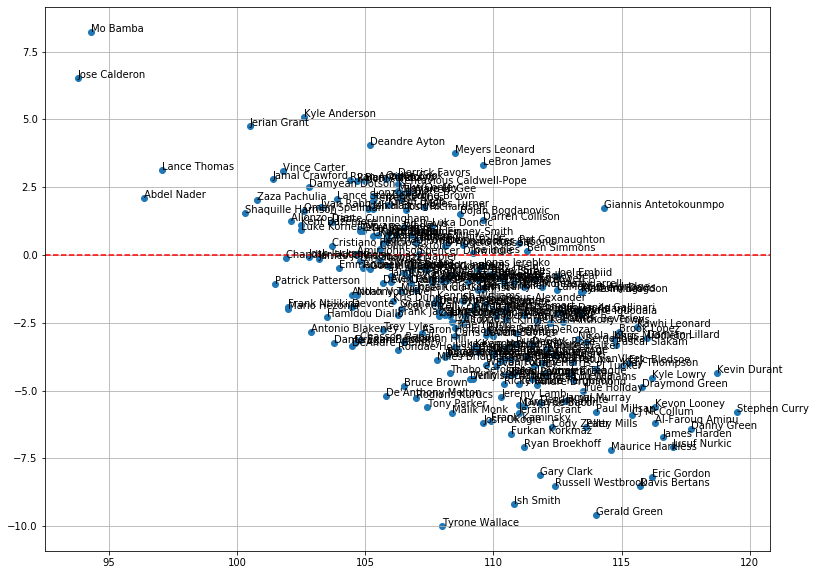

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
plt.title('')
plt.grid()
plt.scatter(y_test.values, y_pred-y_test.values)
plt.xlabel('')
plt.ylabel('')
#xmin, xmax = ax.get_xlim()
#ymin, ymax = ax.get_ylim()
#plt.plot([-150,150], [-150,150], 'r--')
#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
plt.axhline(0, linestyle='--', c='r')
for i, txt in enumerate(df_test.name):
    ax.annotate(txt, (y_test.values[i][0], y_pred[i]-y_test.values[i][0]))


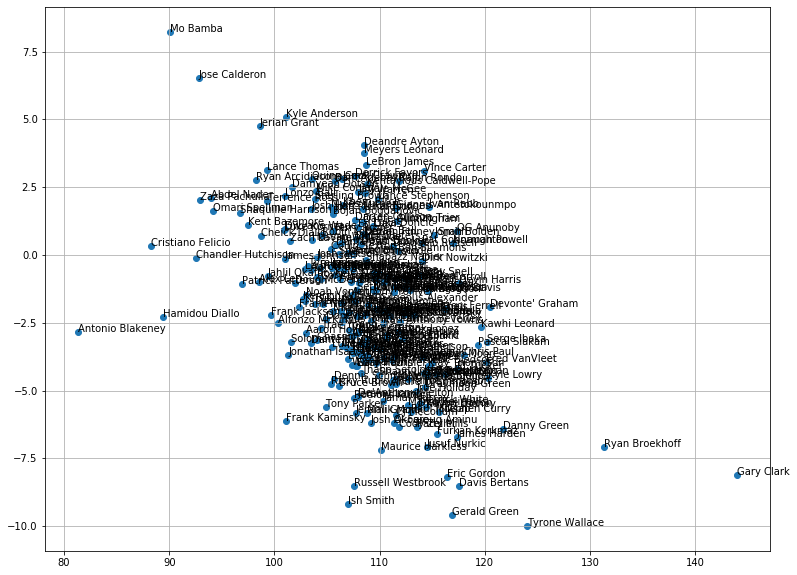

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
plt.title('')
plt.grid()
plt.scatter(df_test.OFFRTGT.values, y_pred-y_test.values)
plt.xlabel('')
plt.ylabel('')
#xmin, xmax = ax.get_xlim()
#ymin, ymax = ax.get_ylim()
#plt.plot([-150,150], [-150,150], 'r--')
#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
#plt.axhline(0, linestyle='--', c='r')
for i, txt in enumerate(df_test.name):
    ax.annotate(txt, (df_test.OFFRTGT.values[i], y_pred[i]-y_test.values[i][0]))


In [11]:
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(x_train, y_train.values.ravel())
y_ridge_pred = ridge_reg.predict(x_test)
for i,pred in enumerate(y_ridge_pred):
    print(str(df_test.name.values[i]) + ' has a predicted +/- of ' + str(pred) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_ridge_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_ridge_pred)))


Aaron Gordon has a predicted +/- of 106.93439042060311 compared to real +/- of 107.40000000000003
Aaron Holiday has a predicted +/- of 104.11689941782447 compared to real +/- of 107.2
Abdel Nader has a predicted +/- of 99.19375962236543 compared to real +/- of 96.40000000000002
Al Horford has a predicted +/- of 110.58582832445377 compared to real +/- of 112.5
Al-Farouq Aminu has a predicted +/- of 109.40073636395151 compared to real +/- of 116.29999999999997
Alex Len has a predicted +/- of 105.26919251009784 compared to real +/- of 106.0
Alfonzo McKinnie has a predicted +/- of 105.85601476370653 compared to real +/- of 108.8
Allen Crabbe has a predicted +/- of 105.71715596387227 compared to real +/- of 106.5
Allonzo Trier has a predicted +/- of 103.67038617108595 compared to real +/- of 102.09999999999998
Amir Johnson has a predicted +/- of 104.72452297716842 compared to real +/- of 104.7
Andre Drummond has a predicted +/- of 107.26353275509628 compared to real +/- of 111.7000000000000

In [ ]:
svr_reg = svm.SVR(gamma='scale')
svr_reg.fit(x_train, y_train.values.ravel())
y_svr_pred = svr_reg.predict(x_test)
#print(y_svr_pred) 
for i,pred in enumerate(y_svr_pred): 
    print(str(df_test.name.values[i]) + ' has a predicted +/- of ' + str(pred) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_svr_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_svr_pred)))


In [ ]:
mlp_reg = MLPRegressor()
mlp_reg.fit(x_train, y_train.values.ravel())
y_mlp_pred = mlp_reg.predict(x_test)
for i,pred in enumerate(y_mlp_pred):
    print(str(df_test.name.values[i]) + ' has a predicted +/- of ' + str(pred) + ' compared to real +/- of ' + str(y_test.values[i][0]))

print('Made', len(y_mlp_pred), 'predictions with a RMS error of', np.sqrt(metrics.mean_squared_error(y_test, y_mlp_pred)))
